In [9]:
# import packages 

# basics
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import markers
from collections import OrderedDict
from itertools import cycle

# scikit-learn imports
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV

# torch imports
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
from torchvision.utils import make_grid

In [35]:
# Check CPU / GPU environment
if torch.cuda.is_available():
    device = torch.device("cuda:0") # Training on GPU
    print("GPU is available")
else:
    device = torch.device("cpu") # Training on CPU
    print("GPU not available, CPU used")

GPU is available


In [10]:
torch.manual_seed(20210412)
np.random.seed(20210412)

# 1. Data Loading & Manipulation

***The CIFAR-10 dataset***
collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton from the University of Toronto. This dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. Each image is a 3-channel colour images of 32x32 pixels in size. There are 50000 training images and 10000 test images.

In [11]:
debug_mode = False

### Download the dataset

In [12]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# Load the training data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

train_batch_size = 1000 if debug_mode else len(trainset)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_batch_size,
                                          shuffle=True, num_workers=2)

# Load the test data
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

test_batch_size = 1000 if debug_mode else len(testset)

testloader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size,
                                         shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') 

Files already downloaded and verified
Files already downloaded and verified


### Pre-processing

In [13]:
# trainset
# convert tensor data(image, label) into numpy array
train_dataset_array, train_dataset_targets =  next(iter(trainloader)) # get a single batch from a trainloader
train_dataset_array = train_dataset_array.numpy()
train_dataset_targets = train_dataset_targets.numpy()

# testset
# convert tensor data(label) into numpy array
test_dataset_array, test_dataset_targets =  next(iter(testloader))
test_dataset_array = test_dataset_array.numpy()
test_dataset_targets = test_dataset_targets.numpy()

In [14]:
# flatten the images for the MLP
d_image, h_image, w_image = train_dataset_array.shape[1:] # (3, 32, 32)->depth(=color) 3*height 32*width 32=3072
X_Train = train_dataset_array.reshape((train_dataset_array.shape[0], d_image*h_image*w_image))

d_image, h_image, w_image = test_dataset_array.shape[1:] # (3, 32, 32)->3*32*32=3072
X_Test = test_dataset_array.reshape((test_dataset_array.shape[0], d_image*h_image*w_image))

# 2. GRID search MLP
### Multi Layer Perceptrons (MLP) model

In [33]:
class MLPNet(nn.Module):
    def __init__(self, input_size, n_hidden_layers, factor):
        super(MLPNet, self).__init__()

        self.input_size = input_size
        self.n_hidden_layers = n_hidden_layers
        self.factor = factor

        temp_width = int(input_size * factor)

        layers = [nn.Linear(input_size, temp_width), nn.ReLU()]

        # create a sequence of linear layers with monotonic 
        # decreases hidden layer widths
        # use ReLU activation after each layer apart from the last
        for i in range(n_hidden_layers - 1):
          if int(temp_width * factor) < 10:
            layers.append(nn.Linear(int(temp_width), int(temp_width)))
          else:
            layers.append(nn.Linear(int(temp_width), int(temp_width * factor)))
            temp_width *= factor
          
          # add ReLU unit for the given layer 
          layers.append(nn.ReLU())
        
        # add the last layer 
        layers.append(nn.Linear(int(temp_width), 10))
        self.linear_layers = nn.Sequential(*layers)
        
    def forward(self, x):
        output = self.linear_layers(x)  
        return output

### Set Hyperparameters

In [34]:
# params for grid search
params = {
    "module__n_hidden_layers" : np.array([3, 5, 7])
    ,"module__factor": np.linspace(1/4, 9/10, 3)
}

In [36]:
device_name = "cuda" if torch.cuda.is_available else "cpu"

net = NeuralNetClassifier(
    MLPNet
    ,criterion = nn.CrossEntropyLoss
    ,optimizer = optim.SGD
    ,module__input_size = 3*32*32
    ,max_epochs = 10
    ,lr = 0.01
    ,optimizer__momentum = 0.9
    ,device = device_name
    ,train_split = False
)  

### Grid Search to find the best parameters

In [37]:
# find the best params
mlp_gs = GridSearchCV(net, params, refit=True, cv=3, scoring='accuracy', verbose=2)

In [38]:
mlp_gs.fit(X_Train, train_dataset_targets)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
  epoch    train_loss     dur
-------  ------------  ------
      1        2.0095  2.2055
      2        1.6459  2.1710
      3        1.4979  2.1756
      4        1.3899  2.2685
      5        1.3007  2.2068
      6        1.2156  2.1894
      7        1.1366  2.2205
      8        1.0587  2.2090
      9        0.9787  2.2050
     10        0.9020  2.1823
[CV] END .....module__factor=0.25, module__n_hidden_layers=3; total time=  23.0s
  epoch    train_loss     dur
-------  ------------  ------
      1        2.0221  2.1609
      2        1.6452  2.1876
      3        1.4921  2.1912
      4        1.3843  2.1740
      5        1.2952  2.2053
      6        1.2148  2.2012
      7        1.1356  2.2011
      8        1.0591  2.1858
      9        0.9846  2.2003
     10        0.9173  2.1899
[CV] END .....module__factor=0.25, module__n_hidden_layers=3; total time=  22.7s
  epoch    train_loss     dur
-------  ------------  -----

      4        2.2001  3.6867
      5        1.9717  3.6856
      6        1.8370  3.6911
      7        1.7358  3.7041
      8        1.6477  3.6861
      9        1.5641  3.6722
     10        1.4741  3.6856
[CV] END ....module__factor=0.575, module__n_hidden_layers=7; total time=  37.9s
  epoch    train_loss     dur
-------  ------------  ------
      1        2.3030  3.6982
      2        2.3022  3.6864
      3        2.2994  3.6846
      4        2.1648  3.6856
      5        1.9310  3.6845
      6        1.8023  3.6858
      7        1.7018  3.6920
      8        1.6064  3.6872
      9        1.4789  3.6831
     10        1.3833  3.6822
[CV] END ....module__factor=0.575, module__n_hidden_layers=7; total time=  37.9s
  epoch    train_loss     dur
-------  ------------  ------
      1        2.3030  3.6795
      2        2.3022  3.7770
      3        2.2963  3.6994
      4        2.0916  3.6989
      5        1.9562  3.6822
      6        1.8084  3.6822
      7        1.6985  3.685

GridSearchCV(cv=3,
             estimator=<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class '__main__.MLPNet'>,
  module__input_size=3072,
),
             param_grid={'module__factor': array([0.25 , 0.575, 0.9  ]),
                         'module__n_hidden_layers': array([3, 5, 7])},
             scoring='accuracy', verbose=2)

In [39]:
mlp_gs.best_params_, mlp_gs.best_score_, mlp_gs.best_estimator_

({'module__factor': 0.9, 'module__n_hidden_layers': 3},
 0.5041794303919515,
 <class 'skorch.classifier.NeuralNetClassifier'>[initialized](
   module_=MLPNet(
     (linear_layers): Sequential(
       (0): Linear(in_features=3072, out_features=2764, bias=True)
       (1): ReLU()
       (2): Linear(in_features=2764, out_features=2487, bias=True)
       (3): ReLU()
       (4): Linear(in_features=2487, out_features=2238, bias=True)
       (5): ReLU()
       (6): Linear(in_features=2238, out_features=10, bias=True)
     )
   ),
 ))

### MLP model test with best parameters from the grid search

In [41]:
mlp_pred = mlp_gs.best_estimator_.predict(X_Test)

mlp_gs_test_accuracy = (mlp_pred == test_dataset_targets).sum()/len(mlp_pred)

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * mlp_gs_test_accuracy))

Accuracy of the network on the 10000 test images: 52 %


### Evalute the classifier performance

<AxesSubplot:>

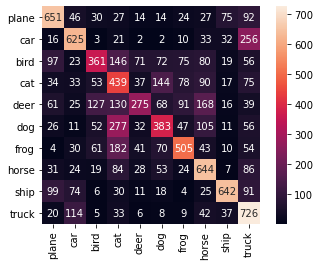

In [42]:
# Show the confusion matrix
target_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
sns.heatmap(confusion_matrix(test_dataset_targets, mlp_pred),
             square=True, annot=True, fmt='d',
             xticklabels = target_names, yticklabels = target_names)

In [43]:
precision_recall_fscore_support(test_dataset_targets, mlp_pred, average='macro')

(0.5375203346327492, 0.5251, 0.5207224082982042, None)

In [44]:
precision_recall_fscore_support(test_dataset_targets, mlp_pred, average='micro')

(0.5251, 0.5251, 0.5251, None)

### MLP Training with Optimization

In [47]:
net = NeuralNetClassifier(
    MLPNet
    ,criterion = nn.CrossEntropyLoss
    ,optimizer = optim.SGD
    ,module__input_size = 3*32*32
    ,max_epochs = 10
    ,lr = 0.01
    ,optimizer__momentum = 0.9
    ,device = device_name
    ,train_split = False
    ,module__n_hidden_layers = mlp_gs.best_params_["module__n_hidden_layers"]
    ,module__factor = mlp_gs.best_params_["module__factor"]
) 

net.fit(X_Train, train_dataset_targets)

  epoch    train_loss      dur
-------  ------------  -------
      1        1.8204  10.8530
      2        1.4824  10.7570
      3        1.3374  10.7355
      4        1.2224  10.7374
      5        1.1179  10.7838
      6        1.0174  10.7160
      7        0.9146  10.5921
      8        0.8105  10.5249
      9        0.7123  10.4963
     10        0.6409  10.5237


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=MLPNet(
    (linear_layers): Sequential(
      (0): Linear(in_features=3072, out_features=2764, bias=True)
      (1): ReLU()
      (2): Linear(in_features=2764, out_features=2487, bias=True)
      (3): ReLU()
      (4): Linear(in_features=2487, out_features=2238, bias=True)
      (5): ReLU()
      (6): Linear(in_features=2238, out_features=10, bias=True)
    )
  ),
)

In [48]:
(net.predict(X_Test) == test_dataset_targets).sum()/len(test_dataset_targets)

0.5325